# Understanding Problem Statement

 Your task is to use unsupervised techniques like SVD, NMF, or PCA, KNN,
etc. to segment the hyperspectral imagery into classes such as land, water,
urban, road etc using band information from all the 242 bands of
hyperspectral data. You have to write a code on python.
You have to find the optimal number of distinct classes in every tileset /
AoI that you select. [(optional) you could scale up the modeling pipeline
task by breaking the tileset in windows and use parallel processing
technology for the same.]

3. Your solution should also have analysis and Html visualizations
included. You could use folium or leaflets on python to create an HTML page
of the clustering result.

# Imports

In [1]:
# General
import numpy as np
import os
import inspect
import re
from typing import Union
from tqdm.notebook import tqdm

# Data Wrangling
from spectral import open_image, imshow
import tifffile as tiff
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
from spectral.graphics import view_cube
import imutils
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import folium
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


# Image processing
from cv2 import cv2
# import rasterio as rst
# import rasterio.warp
# import rasterio
# import rasterio.features
import pickle

# Dimensionality Reduction Algos
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE


# Clustering Algos
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score



# Data Path and Variable Initialisations

In [2]:
root_path = '../'
rawdata_path = root_path+'Raw Data/'
prepareddata_path = root_path+'Prepared Data/'

tileset1_path = rawdata_path+'EO1H0350252010205110KU/'  # Possibly Vegetation
tileset2_path = rawdata_path+'EO1H1430452010208110Kt/'  # Possbly Cloud
tileset3_path = rawdata_path+'EO1H1480472016328110PZ/'  # Looks like mountainregion
bandinfo_path = rawdata_path+'Hyperion Bands.xlsx'

tileset1_img_path = [tileset1_path+k for k in os.listdir(tileset1_path) if '.TIF' in k]
tileset2_img_path = [tileset2_path+k for k in os.listdir(tileset2_path) if '.TIF' in k]
tileset3_img_path = [tileset3_path+k for k in os.listdir(tileset3_path) if '.TIF' in k]


assert len(tileset1_img_path)==242, "All 242 spectrum images are not present"
assert len(tileset2_img_path)==242, "All 242 spectrum images are not present"
assert len(tileset3_img_path)==242, "All 242 spectrum images are not present"


In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (25,5)
plt.rcParams['figure.dpi'] = 180
bandinfo = pd.read_excel(bandinfo_path,index_col=0)
plt.plot((bandinfo.Waveno - 572)<0, color='r')
plt.plot((bandinfo.Waveno - 540)<0, color='g')
plt.plot((bandinfo.Waveno - 430)<0, color='b')
_=plt.grid()
_=plt.xticks(rotation=90)

In [ ]:
bandinfo

In [ ]:
rband = 'B033'
gband = 'B015'
bband = 'B010'

# Helper Functions

In [3]:
class HelperFunctions:
    def __init__(self):
        print('Initialising the Helper Function class...')
        
    def get_varstr(self,var):
        callers_local_vars = inspect.currentframe().f_back.f_locals.items()
        return [var_name for var_name, var_val in callers_local_vars if var_val is var]

    def imgN_show(self, images:Union[np.ndarray,list], titles:Union[list, str]=[], fsize:tuple=(10,10)):
        """
        Helper function to display N number of images, in a grid
        
        parameter
        --------------------
        images : numpy.ndarray (2D, 3D), list
            Can accept an image or a list of images.
            
        titles : Optional
            List of titles equivalent to the length of the images send
        """
        if type(images)==np.ndarray and len(images.shape) == 2:
            images = [images]
        elif type(images)==np.ndarray and len(images.shape) == 3:
            images = [images[:,:,k] for k in range(images.shape[-1])] 
        
        if titles == []:
            titles = ['Image '+str(k+1) for k in range(len(images))]
        _rows = int(np.ceil(len(images)/3))
        _cols = len(images) if len(images)<=3 else 3

        fig = plt.figure(figsize=fsize, dpi = 100)
        grid = ImageGrid(fig, 111, nrows_ncols=(_rows, _cols),axes_pad=0.1)

        for _img , _title, _ax in zip(images, titles, grid):
            if _img.shape[-1] == 3:
                _ax.imshow(imutils.convenience.opencv2matplotlib(_img))
            else:
                _ax.imshow(_img, cmap='gray')
            _ax.set_title(_title)
            _ax.axis('off')

        for _delax in grid[len(images):]:
            fig.delaxes(_delax)

    def load_spectral_data(self, imgpath:list, band_identifier:str, ):
        """
        Reads individual images from imgpath, looks for the band 
        identifier, and then stitches all the bands together 
        """
        pass
        
    def angle_to90(self, img):
        imgproc = (img!=0).astype(int)
        rows,cols = imgproc.shape
        ptA, ptB = (None, None), (None, None)
        idx = 0
        while ptA == (None, None) and idx < cols:
            if sum(imgproc[:,idx])>0:
                ptA = (idx, np.argmax(imgproc[:,idx]))
                break
            idx+=1
        idx=0
        while ptB == (None, None) and idx < rows:
            if sum(imgproc[idx,:])>0:
                ptB = (np.argmax(imgproc[idx,:]),idx)
                break
            idx+=1

        angle = np.rad2deg(np.arctan((ptB[0]-ptA[0])/(ptA[1]-ptB[1])))
        return angle
    
    def crop_image(self, img):
        arr = (np.copy(img)!=0).astype(int)
        row,col = arr.shape
        col1, col2 = 0,0
        for ecol in range(col):
            if sum(arr[:,ecol]) > 0:
                col1 = ecol
                break
        col1-=50
        for ecol in reversed(range(col)):
            if sum(arr[:,ecol]) > 0:
                col2 = ecol
                break
        col2+=50
        return arr[:,col1:col2]
        
    def rotate_image(self, mat, angle):
        """
        Rotates an image (angle in degrees) and expands image to avoid cropping
        """

        height, width = mat.shape[:2] # image shape has 3 dimensions
        image_center = (width/2, height/2) 

        # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape
        rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
        
        # rotation calculates the cos and sin, taking absolutes of those.
        abs_cos = abs(rotation_mat[0,0]) 
        abs_sin = abs(rotation_mat[0,1])

        # find the new width and height bounds
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)

        # subtract old image center (bringing image back to origo) and adding the new image center coordinates
        rotation_mat[0, 2] += bound_w/2 - image_center[0]
        rotation_mat[1, 2] += bound_h/2 - image_center[1]

        # rotate image with the new bounds and translated rotation matrix
        rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
        return rotated_mat

    def prep_specmat(self, imgpaths, band_ident, save_file=''):
        
        if prepareddata_path+save_file in os.listdir(prepareddata_path):
            return np.load(PREPAREDDATA_PATH+save_file)

        def atoi(text):
            return int(text) if text.isdigit() else text
        def natural_keys(text):
            return [atoi(c) for c in re.split(band_ident, text) ]

        paths = sorted(np.copy(imgpaths), key=natural_keys)
        specmat = []
        for epath in paths:
            band_no = re.search(band_ident, epath).group(1)
            specmat.append(tiff.imread(epath))
        specmat = np.dstack(tuple(specmat))
        return specmat
            
    def plot_elbow(self, measures, clust):
        _=plt.plot(clust ,measures)
        _=plt.title('Elbow method using Intertia', fontsize=15)
        _=plt.ylabel('Intertia {SS distance}', fontsize=15)
        _=plt.xlabel('$k$', fontsize=15)
        _=plt.xticks(range(len(clust)), clust)

        
        
    # Requires rasterio installed
    def display_rst_prop(self, imgpath):
        src = rst.open(imgpath)
        print('Data set Name : ', src.name)
        print('Data set Mode : ', src.mode)
        print('Data set Closed : ', src.closed)
        print(f'Coordinate Reference System : {src.crs}')
        print('Number of bands contained : ', src.count)
        print(f'Height x Width : {src.height} x {src.width}')
        print('Band data type : ',{i: dtype for i, dtype in zip(src.indexes, src.dtypes)})
        print('Image bounding Box : ')
        _top, _bottom, _left, _right = src.bounds[3], src.bounds[1], src.bounds[0], src.bounds[2]
        print('\t Left Most Spatial Marker', _left)
        print('\t Right Most Spatial Marker', _right)
        print('\t Bottom Most Spatial Marker', _bottom)
        print('\t Top Most Spatial Marker', _top)
        print(f'\t\t Top Left Coordinates in {src.crs} CRS: {_left, _top}')
        print(f'\t\t Top Right Coordinates in {src.crs} CRS: {_right, _top}')
        print(f'\t\t Bottom Right Coordinates in {src.crs} CRS: {_left, _bottom}')
        print(f'\t\t Bottom Left Coordinates in {src.crs} CRS: {_right, _bottom}\n')
        src_crs_cords = np.array([[_left, _top],
                                  [_right, _top],
                                  [_right, _bottom],
                                  [_left, _bottom]])
        cord_pnames = ['Top Left', 'Top Right', 'Bottom Right', 'Bottom Left']

        for eachname, eachcoord in zip(cord_pnames, src_crs_cords):
            dst_crs = 'EPSG:4326'
            lat,long = rasterio.warp.transform(src_crs= src.crs.__str__(),
                                          dst_crs= 'EPSG:4326',
                                          xs=[eachcoord[0]], ys=[eachcoord[1]])
            print(f'\t\t {eachname} Corrdinates in {dst_crs} CRS : {(lat[0], long[0])}')


        print(f'\n\t Total Width  {_right-_left} mt')
        print(f'\t Total Height {_top-_bottom} mt')

    def to_epsg4326(self, _long, _lat, from_crs='EPSG:32643', to_crs='EPSG:4326'):
        """
        Returns long and lat
        """
        long, lat = rst.warp.transform(src_crs= from_crs,
                                       dst_crs= to_crs,
                                       xs=[_long], ys=[_lat])
        return long[0], lat[0]        
        
        
helperHandler = HelperFunctions()

Initialising the Helper Function class...


# Check for the Shape and Prepare the Spectral Matrix

In [ ]:
img_shape_dict = {'tileset1_img_path':(3441, 1191),
                  'tileset2_img_path':(3521, 1061),
                  'tileset3_img_path':(3481, 1021)}
tot_data_dict = {'tileset1_img_path':886698,
                  'tileset2_img_path':908639,
                  'tileset3_img_path':858445}
tot_data_dict_tst = {'tileset1_img_path':[],
                  'tileset2_img_path':[],
                  'tileset3_img_path':[]}

for eachset in [tileset1_img_path, tileset2_img_path, tileset3_img_path]:
    setname = helperHandler.get_varstr(eachset)[0]
    print(f'Evaluating for {setname}')
    for eachimg in eachset:
        _img = tiff.imread(eachimg)
        _imgchck = sum(sum(_img!=0))
        tot_data_dict_tst[setname].append(_imgchck)
        assert _img.shape == img_shape_dict[setname], f"Different shape than {img_shape}, {_img.shape}"
        
    print(f'All images in {setname} are of shape {img_shape_dict[setname]}\n')

In [ ]:
# ts1_smat = helperHandler.prep_specmat(imgpaths=tileset1_img_path, 
#                                       band_ident=r'_B(\d+)', save_file='ts1.pkl.npy')
# ts2_smat = helperHandler.prep_specmat(imgpaths=tileset2_img_path, 
#                                       band_ident=r'_B(\d+)', save_file='ts2.pkl.npy')
# ts3_smat = helperHandler.prep_specmat(imgpaths=tileset3_img_path, 
#                                       band_ident=r'_B(\d+)', save_file='ts3.pkl.npy')
# print('Shape of the First tile set - Spectral ',ts1_smat.shape)
# print('Shape of the Second tile set - Spectral ',ts2_smat.shape)
# print('Shape of the Third tile set - Spectral ',ts3_smat.shape)

# Data Processing

In [4]:
# Which tileset is being processed
tileset_no = 3

_pths1 = {1:tileset1_img_path.copy(),
          2:tileset2_img_path.copy(),
          3:tileset3_img_path.copy()}
_pths2 = {1:'tileset1',
          2:'tileset2',
          3:'tileset3'}

imgpaths= _pths1[tileset_no]

savefile0 = prepareddata_path+f'{_pths2[tileset_no]}/tile{tileset_no}_orig.pkl'
savefile1 = prepareddata_path+f'{_pths2[tileset_no]}/tile{tileset_no}_rotated.pkl'
savefile2 = prepareddata_path+f'{_pths2[tileset_no]}/tile{tileset_no}_slice.pkl'
savefile3 = prepareddata_path+f'{_pths2[tileset_no]}/tile{tileset_no}_slice_mean.pkl'
savefile4 = prepareddata_path+f'{_pths2[tileset_no]}/tile{tileset_no}_slice_RGB.pkl'
savefile5 = prepareddata_path+f'{_pths2[tileset_no]}/tile{tileset_no}_slice_BGR.pkl'
savefile6 = prepareddata_path+f'{_pths2[tileset_no]}/tile{tileset_no}_orig_coord.pkl'
savefile7 = prepareddata_path+f'{_pths2[tileset_no]}/tile{tileset_no}_trsf_coord.pkl' # to be loaded
savefile8 = prepareddata_path+f'{_pths2[tileset_no]}/tile{tileset_no}_geom.pkl' # to be loaded
savefile9 = prepareddata_path+f'{_pths2[tileset_no]}/tile{tileset_no}_classmask.html' # to be loaded



os.makedirs(prepareddata_path+f'{_pths2[tileset_no]}/', exist_ok=True)


**Calculating the average *ANGLE TO 90* for tileset images**

In [ ]:
indangles = []
for epath in imgpaths:
    indangles.append(helperHandler.angle_to90(tiff.imread(epath)))
plt.plot(indangles)
_=plt.title('Variation in angle to 90')
mean_angleto90 = np.mean(indangles)
_=plt.hlines(mean_angleto90,0,260, color='r')
print('Average angle to 90 : ', np.mean(mean_angleto90))

**Rotation and Concatanation**
- Rotate each image to mean angle to 90
- Concatanate each bands to a single matrix

In [ ]:

origimg = tiff.imread(imgpaths[37])
rotatedimg = helperHandler.rotate_image(origimg, mean_angleto90)
helperHandler.imgN_show([origimg, rotatedimg], 
                        titles=[f'Original{origimg.shape}', f'Rotated{rotatedimg.shape}'],
                        fsize=(6,10))


In [ ]:
specmat_orig = []
specmat = []
for epath in tqdm(imgpaths):
    oimg = tiff.imread(epath)
    rotimg = helperHandler.rotate_image(oimg, mean_angleto90)
    specmat.append(rotimg)
    specmat_orig.append(oimg)
    
specmat_orig = np.dstack(tuple(specmat_orig))
specmat = np.dstack(tuple(specmat))

print('Orignal Spectral matrix shape : ', specmat_orig.shape)
print('Rotated Spectral matrix shape : ', specmat.shape)


**GET ORIGINAL SPECMAT DATA EXTREME COORDINATES**

In [ ]:
specmat_orig_mean = specmat_orig.mean(axis=2)
specmat_orig_mean_mask2d = (specmat_orig_mean>0).astype(int)

# Get top left
_topleft = ()
for each in range(specmat_orig_mean_mask2d.shape[0]):
    idx = list(np.where(specmat_orig_mean_mask2d[each,:]==1)[0])
    if idx !=[]:
        _topleft = (each, idx[0])
        break

# Get bottom right
_bottomright = ()
for each in reversed(range(specmat_orig_mean_mask2d.shape[0])):
    idx = list(np.where(specmat_orig_mean_mask2d[each,:]==1)[0])
    if idx !=[]:
        _bottomright = (each, idx[0])
        break

        
# Get bottom left
_bottomleft = ()
for each in range(specmat_orig_mean_mask2d.shape[1]):
    idx = list(np.where(specmat_orig_mean_mask2d[:,each]==1)[0])
    if idx !=[]:
        _bottomleft = (idx[0],each)
        break
        
        
# Get top right
_topright = ()
for each in reversed(range(specmat_orig_mean_mask2d.shape[1])):
    idx = list(np.where(specmat_orig_mean_mask2d[:,each]==1)[0])
    if idx !=[]:
        _topright = (idx[0],each)
        break

        
coord_dict = {'top_left':_topleft,
              'top_right':_topright,
              'bottom_right':_bottomright,
              'bottom_left':_bottomleft}
coord_dict
# with open(savefile6, 'wb') as handle:
#     pickle.dump(coord_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

**CONVERT TO LAT AND LONG**

In [ ]:
with open(savefile7, 'rb') as handle:
    transformed_cord = pickle.load(handle)
print(transformed_cord)

with open(savefile8, 'rb') as handle:
    geom = pickle.load(handle)
geom



**CHECK FOLIUM OVERLAY**

In [ ]:
m = folium.Map(location=geom['coordinates'][0][0][::-1],
               position='topright',
               zoom_start=8)
folium.GeoJson(geom, name='geojson').add_to(m)

for k,v in transformed_cord.items():
    folium.Marker([v[1],v[0]], popup=k).add_to(m)

# folium.raster_layers.ImageOverlay(image=specmat_sliced_mean,# Longitude # Latitude
#                                   bounds=[geom['coordinates'][0][0][::-1],
#                                           geom['coordinates'][0][2][::-1]],
#                                   origin='upper',
#                                   opacity=0.5,
#                                   colormap=plt.cm.get_cmap('viridis'),
#                                   mercator_project=False,
#                                   pixelated=True,
#                                   name=None,
#                                   overlay=True,
#                                   control=True,
#                                   show=True).add_to(m)
m

**Sum over the third axis and create a mask**

In [ ]:
# Data Mask for 
volume_sum   = specmat.sum(axis=2)
volume_mean  = specmat.mean(axis=2)
volume_meanmask2d = volume_mean>0

helperHandler.imgN_show(images=[volume_sum, volume_mean, volume_meanmask2d], 
                        titles=['Volume Sum', 'Volume Mean (Act.)', 'Volume Mask'],
                        fsize=(10,6))

xmin, xmax = np.where(volume_meanmask2d)[0].min(), np.where(volume_meanmask2d)[0].max()
ymin, ymax = np.where(volume_meanmask2d)[1].min(), np.where(volume_meanmask2d)[1].max()

ptA = (xmin,ymin)
ptB = (xmax,ymin)
ptC = (xmax,ymax)
ptD = (xmin,ymax)

print('Point A : ', ptA)
print('Point B : ', ptB)
print('Point C : ', ptC)
print('Point D : ', ptD)

**Slice specmat from the original volume, & save the sliced file**

In [ ]:
print('Original Matrix Shape:',specmat.shape)
specmat_sliced = specmat[ptA[0]:ptB[0]+1, ptB[1]:ptC[1]+1,:].copy()
print('Sliced Matrix Shape :',specmat_sliced.shape)
helperHandler.imgN_show(images=[specmat.mean(axis=2), specmat_sliced.mean(axis=2)],
                        titles=['Total Volume Mean', 'Sliced Volume Mean'])


In [ ]:
specmat_sliced_sum = specmat_sliced.sum(axis=2)
specmat_sliced_sum_norm = specmat_sliced_sum/specmat_sliced_sum.max()
specmat_sliced_mean = specmat_sliced.mean(axis=2)
specmat_sliced_mean_norm = specmat_sliced_mean/specmat_sliced_mean.max()

print('Spectral Slice Sum : ', specmat_sliced_sum.shape)
print('Spectral Slice Mean : ', specmat_sliced_mean.shape)

**RGB AND BGR IMAGE BAND SLICE STACKED**

In [ ]:
redband_slice = specmat_sliced[:,:,21]
greenband_slice = specmat_sliced[:,:,19]
blueband_slice = specmat_sliced[:,:,7]

# RGB and BGR stack for the image
rgb_slice = np.dstack((redband_slice,
                       greenband_slice,
                       blueband_slice))
bgr_slice = np.dstack((blueband_slice,
                       greenband_slice,
                       redband_slice))
specmat_rgb_sliced = rgb_slice.astype(np.uint8)
specmat_bgr_sliced = bgr_slice.astype(np.uint8)

helperHandler.imgN_show([specmat_bgr_sliced, specmat_rgb_sliced], 
                        titles=['BGR Stacking', 'RGB Stacking']) # Look into cmap

**SAVE DATA**

In [ ]:

# np.save(prepareddata_path+savefile0, specmat_orig)
# np.save(prepareddata_path+savefile1, specmat)
# np.save(prepareddata_path+savefile2, specmat_sliced)
# np.save(prepareddata_path+savefile3, specmat_sliced_mean)
# np.save(prepareddata_path+savefile4, specmat_rgb_sliced)
# np.save(prepareddata_path+savefile5, specmat_bgr_sliced)


**LOAD DATA**

In [5]:

specmat_orig = np.load(prepareddata_path+savefile0+'.npy')
specmat = np.load(prepareddata_path+savefile1+'.npy')
specmat_sliced = np.load(prepareddata_path+savefile2+'.npy')
specmat_sliced_mean = np.load(prepareddata_path+savefile3+'.npy')
specmat_rgb_sliced = np.load(prepareddata_path+savefile4+'.npy')
specmat_bgr_sliced = np.load(prepareddata_path+savefile5+'.npy')
with open(savefile7, 'rb') as handle:
    transformed_cord = pickle.load(handle)

with open(savefile8, 'rb') as handle:
    geom = pickle.load(handle)


print('Spectral Original Data Shape : ', specmat_orig.shape)
print('Spectral Data Shape : ', specmat.shape)
print('Spectral Slice Shape : ', specmat_sliced.shape)
print('Spectral Slice Mean : ', specmat_sliced_mean.shape)
print('Spectral RGB  : ', specmat_rgb_sliced.shape)
print('Spectral BGR : ', specmat_bgr_sliced.shape)


Spectral Original Data Shape :  (3481, 1021, 242)
Spectral Data Shape :  (3620, 1762, 242)
Spectral Slice Shape :  (3496, 249, 242)
Spectral Slice Mean :  (3496, 249)
Spectral RGB  :  (3496, 249, 3)
Spectral BGR :  (3496, 249, 3)


# Spectral Analysis

- https://www.youtube.com/watch?v=vxh53StWaUk




**OBSERVATIONS**
- Given the scale of the pixel value , maybe they represent the Irradiance.


In [ ]:
mask_palette = [eval(k) for k in ['(230, 25, 75)', 
                                    '(60, 180, 75)', 
                                    '(255, 225, 25)', 
                                    '(0, 130, 200)', 
                                    '(245, 130, 48)', 
                                    '(145, 30, 180)', 
                                    '(70, 240, 240)', 
                                    '(240, 50, 230)', 
                                    '(210, 245, 60)', 
                                    '(250, 190, 212)', 
                                    '(0, 128, 128)', 
                                    '(220, 190, 255)', 
                                    '(170, 110, 40)', 
                                    '(255, 250, 200)', 
                                    '(128, 0, 0)', 
                                    '(170, 255, 195)', 
                                    '(128, 128, 0)', 
                                    '(255, 215, 180)', 
                                    '(0, 0, 128)', 
                                    '(128, 128, 128)', 
                                    '(255, 255, 255)', 
                                    '(0, 0, 0)']]

**ANALYSING BANDS OF THE SPECTRAL SLICE**

In [ ]:
top_bands = specmat_sliced.sum(axis=0).sum(axis=0).argsort()[-6:][::-1]
helperHandler.imgN_show(specmat_sliced[:,:,top_bands[0]].T, 
                        titles = [f'Band {top_bands[0]}'],
                        fsize=(10,5))
print('Top 6 Spectral bands with most values ', top_bands)

In [ ]:
# Pick a random pixel from the MXN spatial space and plot the wavelength variation 
ran_r = np.random.choice(range(specmat_sliced.shape[0]), 50)
ran_c = np.random.choice(range(specmat_sliced.shape[1]), 50)
ran_pxls = [(k,v) for k,v in zip(ran_c,ran_r)]
_=plt.plot(specmat_sliced[ran_r,ran_c,:].T)


In [ ]:
class SpectralPixAnalysis:
    def __init__(self, spectral_data, spectral_img = None):
        self.specfig, self.specaxes = plt.subplots(nrows=3,ncols=1,
                                                    gridspec_kw={'height_ratios': [1, 2, 2]},
                                                    figsize=(13,11))
        plt.tight_layout()
        self.spectral_data = spectral_data.copy()
        if spectral_img is None:
            self.spectral_img = spectral_data.mean(axis=2).T
        else:
            self.spectral_img = spectral_img.copy()
        self.img_h, self.img_w = self.spectral_img.shape
        
        self.prev_line_x, self.prev_line_y, self.specplt = None, None, None
        self.retain_dict = {}
        
        # Connect the event handlers to the plot
        self.specfig.canvas.mpl_connect('motion_notify_event', self.enter_axes)
        self.specfig.canvas.mpl_connect('button_press_event', self.mouse_clicked)
        
        # Plot the HSI image
        self.specaxes[0].imshow(self.spectral_img, cmap='gray', aspect='auto')
        
        # Set labels for the 
        self.specaxes[1].set_xlabel(r'$\lambda\ Band No.\longrightarrow$',fontsize=10)
        self.specaxes[1].set_ylabel(r'$Irradiance$',fontsize=10)

        # Set the y limits for the last two plots
        self.specaxes[1].set_ylim(0,self.spectral_data.max())
        self.specaxes[2].set_ylim(0,self.spectral_data.max())
        self.specaxes[1].grid()
        self.specaxes[2].grid()

    def enter_axes(self, event):
        if event.inaxes == self.specaxes[0]:
            ax=event.inaxes
            if self.prev_line_x != None:
                self.prev_line_x.remove()

            if self.prev_line_y != None:
                self.prev_line_y.remove()
                
            if self.specplt != None:
                self.specplt[0].remove()

            x_pixel, y_pixel = int(event.xdata), int(event.ydata)
            
            self.prev_line_x=ax.vlines(x_pixel,0,self.img_h-2,color='r',linewidth=1,linestyle=':')
            self.prev_line_y=ax.hlines(y_pixel,0,self.img_w-2,color='r',linewidth=1,linestyle=':')
            
            spectral_data = self.spectral_data[x_pixel,y_pixel,:]
            self.specplt = self.specaxes[1].plot(spectral_data)
    
    def mouse_clicked(self,event):
        if event.inaxes==self.specaxes[0]:

            x_pixel, y_pixel = int(event.xdata), int(event.ydata)
            spectral_data = self.spectral_data[x_pixel,y_pixel,:]
    
            self.retain_dict[f'Pixel_({x_pixel},{y_pixel})'] = spectral_data
            try:
                self.specaxes[2].get_legend().remove()
                for each in self.specaxes[2].lines:
                    each.remove()
            except:
                pass
        
            for k,v in self.retain_dict.items():
                self.specaxes[2].plot(v, label=k)
                self.specaxes[2].legend()
    


In [ ]:
%matplotlib notebook
%matplotlib notebook
specAnalysisTab = SpectralPixAnalysis(spectral_data = specmat_sliced, 
                                      spectral_img = specmat_sliced_mean.T)


# Unsupersvised Classification


- DIMENSIONALITY REDUCTION :
    - Mean across all channels and then clustering
    - Deviation from the Average and then clustering
    - PCA
    - NMF
    - SVD
    - t-SNE
    

- UNSUPERVISED CLUSTERING 
    - Linear Mixing Models
    - kMeans
    - Gaussian Mixture Models
    
    
- FEATURE ENGGINEERING
    - Glcm +

**Metrics for Performance**
- Sum of Squared Error and the classification trade off

In [6]:
all_classification_masks = {}
print('Total Datapoints (pixels) ', specmat_sliced.shape[0]*specmat_sliced.shape[1])

Total Datapoints (pixels)  870504


## Dimensionality Reduction

### Mean

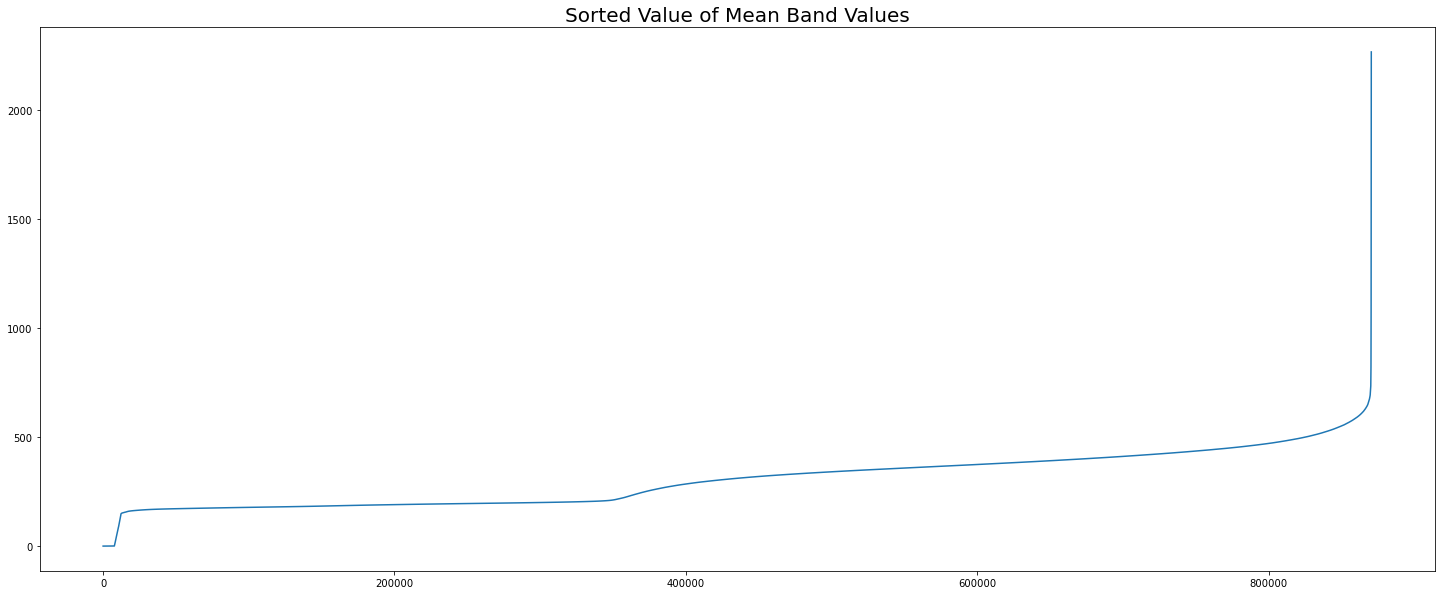

In [7]:
%matplotlib inline

specmat_sliced_DR_mean = specmat_sliced_mean.reshape(specmat_sliced_mean.shape[0]*specmat_sliced_mean.shape[1],1)
meanUCdf = pd.DataFrame(specmat_sliced_DR_mean, columns=['mean_val'])
plt.rcParams['figure.figsize'] = (25,10)
_=meanUCdf.mean_val.sort_values().reset_index().drop('index',axis=1).mean_val.plot()
_=plt.title('Sorted Value of Mean Band Values', fontsize=20)


### Standard Deviation

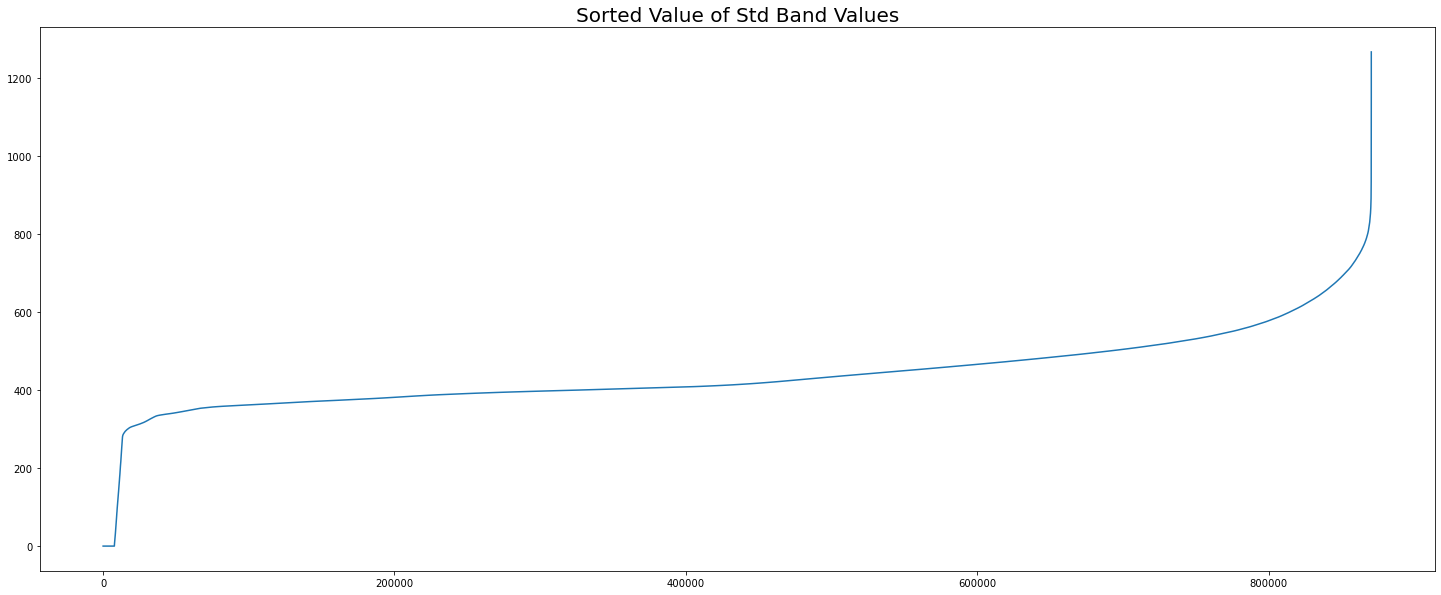

In [8]:
%matplotlib inline

specmat_sliced_DR_std = specmat_sliced.std(axis=2).reshape(specmat_sliced_mean.shape[0]*specmat_sliced_mean.shape[1],1)
stdUCdf = pd.DataFrame(specmat_sliced_DR_std, columns=['std_val'])
plt.rcParams['figure.figsize'] = (25,10)
_=stdUCdf.std_val.sort_values().reset_index().drop('index',axis=1).std_val.plot()
_=plt.title('Sorted Value of Std Band Values', fontsize=20)


### PCA

In [9]:
specmat_sliced_2d = specmat_sliced.reshape(specmat_sliced.shape[0]*specmat_sliced.shape[1],
                                           specmat_sliced.shape[2]).copy()
scaler = StandardScaler()
specmat_sliced_2d_scaled = scaler.fit_transform(specmat_sliced_2d)
check = specmat_sliced_2d[:,37].reshape(specmat_sliced.shape[0], specmat_sliced.shape[1]) != specmat_sliced[:,:,37]

print('No of unequal values :',sum(sum(check)))
print('Specmat 2 Dimension :', specmat_sliced_2d.shape)
print('Specmat 2d scaled :', specmat_sliced_2d_scaled.shape)

No of unequal values : 0
Specmat 2 Dimension : (870504, 242)
Specmat 2d scaled : (870504, 242)


In [10]:

pca = PCA(n_components=100, svd_solver='full')
specmat_sliced_DR_pca = pca.fit_transform(specmat_sliced_2d_scaled)
pca_df = pd.DataFrame(specmat_sliced_DR_pca)


In [ ]:

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15,5)

fig,axes = plt.subplots(1,2)
_=axes[0].plot(pca.explained_variance_ratio_.cumsum()[:10])
_=axes[0].set_title('Cummulative Variance Plot')

_=axes[1].scatter(specmat_sliced_DR_pca[:,0], specmat_sliced_DR_pca[:,1],
                  s=.1)
_=axes[1].set_title('PC1 and PC2')
_=fig.suptitle('Principal Components', fontsize=15)


In [ ]:
# %matplotlib notebook
# %matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x=specmat_sliced_DR_pca[:,0].copy()
y=specmat_sliced_DR_pca[:,1].copy()
z=specmat_sliced_DR_pca[:,2].copy()
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')

_=ax.scatter(x,y,z,s=0.1)


In [ ]:
pca.explained_variance_ratio_.cumsum()[7]

In [ ]:
%matplotlib inline

### SVD

In [ ]:

svd = TruncatedSVD(n_components=99, n_iter=7, random_state=42)
specmat_sliced_DR_svd =svd.fit_transform(specmat_sliced_2d_scaled)
svd_df = pd.DataFrame(specmat_sliced_DR_svd)


In [ ]:

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15,5)

fig,axes = plt.subplots(1,2)
_=axes[0].plot(svd.explained_variance_ratio_.cumsum()[:10])
_=axes[0].set_title('Cummulative Variance Plot')
_=axes[0].set_xlabel('Component No.')
_=axes[0].set_ylabel('Cummulative Variance Explained')

_=axes[1].scatter(specmat_sliced_DR_svd[:,0], specmat_sliced_DR_svd[:,1],
                  s=.1)
_=axes[1].set_title('Component 1 and Component 2')
_=axes[1].set_xlabel('Component 1')
_=axes[1].set_ylabel('Component 2')
_=fig.suptitle('SVD Decomposition', fontsize=15)


In [ ]:
%matplotlib notebook
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x=specmat_sliced_DR_svd[:,0].copy()
y=specmat_sliced_DR_svd[:,1].copy()
z=specmat_sliced_DR_svd[:,2].copy()
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')

_=ax.scatter(x,y,z,s=0.1)


In [ ]:
%matplotlib inline

### NMF
- Taking way too long for processing

In [ ]:

specmat_sliced_2d_01scaled = specmat_sliced_2d/specmat_sliced_2d.max(axis=0)

nmf = NMF(n_components=100, init='random', random_state=0)
specmat_sliced_DR_nmf =nmf.fit_transform(specmat_sliced_2d_01scaled)
nmf_df = pd.DataFrame(specmat_sliced_DR_nmf)


In [ ]:

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15,5)

fig,axes = plt.subplots(1,1)

_=axes[1].scatter(specmat_sliced_DR_nmf[:,0], specmat_sliced_DR_nmf[:,1],
                  s=.1)
_=axes[1].set_title('Component 1 and Component 2')
_=axes[1].set_xlabel('Component 1')
_=axes[1].set_ylabel('Component 2')
_=fig.suptitle('NMF Decomposition', fontsize=15)


In [ ]:
%matplotlib notebook
%matplotlib notebook

fig = plt.figure()
ax = Axes3D(fig)

x=specmat_sliced_DR_nmf[:,0].copy()
y=specmat_sliced_DR_nmf[:,1].copy()
z=specmat_sliced_DR_nmf[:,2].copy()
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')

_=ax.scatter(x,y,z,s=0.1)


In [ ]:
%matplotlib inline

### Combining Mean+std+PC1+PC2

In [11]:
b1 = specmat_sliced_mean
b2 = specmat_sliced.std(axis=2)
b3 = specmat_sliced_DR_pca[:,0].reshape(specmat_sliced.shape[0],specmat_sliced.shape[1])
b4 = specmat_sliced_DR_pca[:,1].reshape(specmat_sliced.shape[0],specmat_sliced.shape[1])


comb =  np.dstack((b1,b2,b3,b4))
specmat_sliced_DR_comb = comb.reshape(specmat_sliced_mean.shape[0]*specmat_sliced_mean.shape[1],4)
comb_df = pd.DataFrame(specmat_sliced_DR_comb, columns=['mean','std','pc1','pc2'])


In [ ]:
# %matplotlib notebook
# %matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x=specmat_sliced_DR_comb[:,3].copy()
y=specmat_sliced_DR_comb[:,1].copy()
z=specmat_sliced_DR_comb[:,2].copy()
ax.set_xlabel('PC 2')
ax.set_ylabel('STD')
ax.set_zlabel('PC 1')

_=ax.scatter(x,y,z,s=0.1)


In [ ]:
%matplotlib inline

### Combining Mean+std+PC[0:8]

In [12]:
b1 = specmat_sliced_mean
b2 = specmat_sliced.std(axis=2)
b3 = specmat_sliced_DR_pca[:,:8].reshape(specmat_sliced.shape[0],specmat_sliced.shape[1],8)


combstrt1 =  np.dstack((b1,b2,b3))
specmat_sliced_DR_combstrt1 = combstrt1.reshape(specmat_sliced_mean.shape[0]*specmat_sliced_mean.shape[1],10)
combstrt1_df = pd.DataFrame(specmat_sliced_DR_combstrt1, columns=['mean','std','pc1','pc2',
                                                                    'pc3','pc4','pc5','pc6',
                                                                    'pc7','pc8'])

print('Shapre of the matrix : ', specmat_sliced_DR_combstrt1.shape)

Shapre of the matrix :  (870504, 10)


In [ ]:
helperHandler.imgN_show(combstrt1.mean(axis=2).T)

### Autoencoders

### SOM

## Unsupervised Clustering

In [ ]:
dr_mode = 'combstrt1'
matrix_X = specmat_sliced_DR_combstrt1.copy() # Matrix to cluster, must be 2 dimensional
matrix = combstrt1_df.copy()
print('No of no similar elements :', sum(sum(matrix.values != matrix_X)))

print('Shape of the matrix : ', matrix.shape)
print('Shape of the feature matrix : ', matrix_X.shape)
print('Dimensionality Reduction Mode : ', dr_mode)

### kMeans

In [ ]:
%matplotlib inline
clst_mode = 'kmeans'
kmeans_intertia_dict = {}
clusters = [k for k in range(1,10)]
for i in tqdm(clusters):
    km = KMeans(n_clusters=i)
    km.fit(matrix_X)
    kmeans_intertia_dict[i] = km.inertia_
    _labels = km.predict(matrix_X)
    matrix[dr_mode+'_'+clst_mode+f'_c{i}'] = _labels
    all_classification_masks[dr_mode+'_'+clst_mode+f'_c{i}'] = _labels.reshape(specmat_sliced.shape[0], 
                                                                               specmat_sliced.shape[1])

helperHandler.plot_elbow(measures = list(kmeans_intertia_dict.values()),
                            clust = clusters)

In [ ]:
helperHandler.imgN_show([all_classification_masks['combstrt1_kmeans_c6'].T])

### GMM

In [ ]:
%matplotlib inline
clst_mode = 'gmm'
bic_scores = []
clusters = [k for k in range(1,10)]
for i in tqdm(clusters):
    gmm_model = GaussianMixture(n_components=i)
    _labels = gmm_model.fit_predict(matrix_X)
    matrix[dr_mode+'_'+clst_mode+f'_c{i}'] = _labels
    all_classification_masks[dr_mode+'_'+clst_mode+f'_c{i}'] = _labels.reshape(specmat_sliced.shape[0], 
                                                                               specmat_sliced.shape[1])
    bic_scores.append(gmm_model.bic(matrix_X))
    
_=plt.plot(clusters,bic_scores)

In [ ]:
helperHandler.imgN_show([all_classification_masks['combstrt1_gmm_c6'].T])

### Hierarichal Clustering
- Data too big

In [ ]:

%matplotlib inline
clst_mode = 'agg_hierch'
clusters = [k for k in range(1,10)]
for i in tqdm(clusters):
    aggc_model = AgglomerativeClustering(n_clusters=i)
    _labels = aggc_model.fit_predict(matrix_X)
    matrix[dr_mode+'_'+clst_mode+f'_c{i}'] = _labels
    all_classification_masks[dr_mode+'_'+clst_mode+f'_c{i}'] = _labels.reshape(specmat_sliced.shape[0], 
                                                                               specmat_sliced.shape[1])
    


## Save Results

In [ ]:
# Which tileset is being processed
os.makedirs(prepareddata_path+f'{_pths2[tileset_no]}/Clustering_Results/', exist_ok=True)

for k,v in all_classification_masks.items():
    if len(v)>0:
        path = prepareddata_path+f'{_pths2[tileset_no]}/Clustering_Results/{k}.pkl'
        np.save(path,v)


# Result Analysis


In [13]:
# Load Mask data
all_classification_masks = {}
path = prepareddata_path+f'{_pths2[tileset_no]}/Clustering_Results/'
for each in os.listdir(path):
    maskname = each.split('.')[0]
    all_classification_masks[maskname] = np.load(path+each)
    

**Sillihoute Score**

In [14]:
unique_data = np.unique(["_".join(k.split('_')[:-2]) for k in all_classification_masks.keys()])
unique_models = np.unique(["_".join(k.split('_')[:-1]) for k in all_classification_masks.keys()])
metricDF = pd.DataFrame(columns=unique_models)
print('Unique Data Reductions :', unique_data)
for eachkey, eachmask in tqdm(all_classification_masks.items()):
    _clusters = re.search('_c(\d+)', eachkey).group(1)
    _drmode = "_".join(eachkey.split('_')[:-2]) 
    _drclstmode = "_".join(eachkey.split('_')[:-1])
    if _drmode=='comb':
        _X = specmat_sliced_DR_comb.copy()
    elif _drmode=='combstrt1':
        _X = specmat_sliced_DR_combstrt1.copy()
    elif _drmode=='mean':
        _X=specmat_sliced_DR_mean.copy()
    elif _drmode=='pca_100':
        _X = specmat_sliced_DR_pca.copy()
    elif _drmode=='pca_25':
        _X = specmat_sliced_DR_pca[:,:25].copy()        
    elif _drmode=='std':
        _X = b2.reshape(specmat_sliced.shape[0]*specmat_sliced.shape[1],1).copy()

    _labels = all_classification_masks['mean_gmm_c9'].copy().ravel()
    _sscore = silhouette_score(X=_X, labels=_labels, sample_size=10000)
    metricDF.loc[_clusters,_drclstmode] = _sscore


Unique Data Reductions : ['comb' 'combstrt1' 'mean' 'pca_100' 'pca_25' 'std']


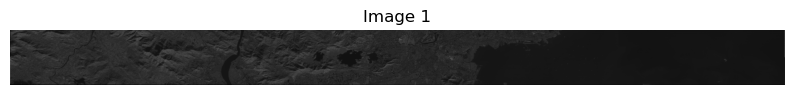

In [15]:
helperHandler.imgN_show(specmat_sliced_mean.T)

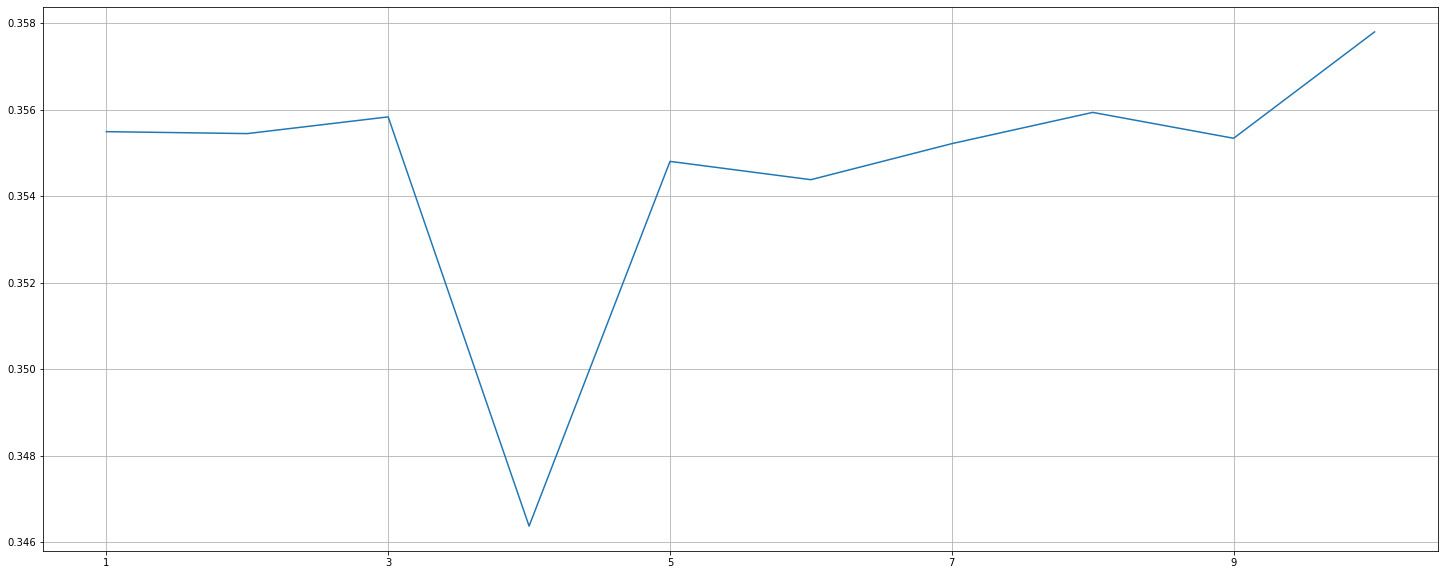

In [16]:
metricDF.iloc[:10,:].mean(axis=1).plot()
plt.grid()

In [17]:
class HSClusterAnalysis:
    
    def __init__(self, spectral_data, spectral_img, class_masks:dict,):
        
        # Initialise Data
        self.spectral_data = spectral_data.copy()
        if spectral_img is None:
            self.spectral_img = spectral_data.mean(axis=2).T
        else:
            self.spectral_img = spectral_img.T.copy()
        self.img_h, self.img_w = self.spectral_img.shape
        self.class_masks = class_masks
        
        # Initialise Figure parameters
        plt.rcParams['figure.figsize'] = (13.5,12)
        self.clsfig = plt.figure(constrained_layout=True)
        spec = gridspec.GridSpec(ncols=4, nrows=6, figure=self.clsfig)
        
        self.f_ax0 = self.clsfig.add_subplot(spec[0, :]) # Image Tile
        self.f_ax0c = self.clsfig.add_subplot(spec[1, :]) # Image Class Tile

        self.f_ax10 = self.clsfig.add_subplot(spec[2, 0]) # Individual Algo slice plots
        self.f_ax11 = self.clsfig.add_subplot(spec[2, 1]) # Individual Algo slice plots
        self.f_ax12 = self.clsfig.add_subplot(spec[2, 2]) # Individual Algo slice plots
        self.f_ax13 = self.clsfig.add_subplot(spec[2, 3]) # Individual Algo slice plots
        
        self.f_ax20 = self.clsfig.add_subplot(spec[3, 0]) # Individual Algo slice plots
        self.f_ax21 = self.clsfig.add_subplot(spec[3, 1]) # Individual Algo slice plots
        self.f_ax22 = self.clsfig.add_subplot(spec[3, 2]) # Individual Algo slice plots
        self.f_ax23 = self.clsfig.add_subplot(spec[3, 3]) # Individual Algo slice plots

        self.f_ax3 = self.clsfig.add_subplot(spec[-2:, :]) # Analysis plot

        self.sq_axes = [self.f_ax10,  self.f_ax11, self.f_ax12, self.f_ax13,
                        self.f_ax20, self.f_ax21, self.f_ax22, self.f_ax23]
        self.axes_mapping = {k.upper():v for k,v in zip(class_masks.keys(), self.sq_axes)}

        # Set titles
        for eachtitle,eachax in self.axes_mapping.items():
            eachax.set_title(eachtitle.upper(), fontsize=10)
            
        
        self.prev_line_x, self.prev_line_y, self.specplt = [],[],None
        self.retain_dict = {}
        
        # Prepare the masks images for each of the models
        self.f_ax0.imshow(self.spectral_img,cmap='gray')
        self.hoverpatch = Rectangle((0,0), self.img_h, self.img_h, alpha=0.5)
        self.f_ax0.add_artist(self.hoverpatch)
        
        # Connect the event handlers to the plot
        self.clsfig.canvas.mpl_connect('button_press_event', self.click_axes)
        self.clsfig.canvas.mpl_connect('motion_notify_event', self.hover_axes)
    
    def click_axes(self, event):
        x_pixel, y_pixel = int(event.xdata), int(event.ydata)

        if event.inaxes == self.f_ax0:
            ax=event.inaxes
            if self.hoverpatch != None:
                self.hoverpatch.remove()
                
            if int(x_pixel)>self.img_h/2 and int(x_pixel)<self.img_w - self.img_h/2:
                hvr_x = int(x_pixel)-self.img_h/2
            elif int(x_pixel)<=self.img_h/2:
                hvr_x = 0
            elif int(x_pixel)>=self.img_w - self.img_h:
                hvr_x = self.img_w - self.img_h
    
            self.hoverpatch = Rectangle((hvr_x,0), self.img_h, self.img_h, alpha=0.5)
            self.f_ax0.add_artist(self.hoverpatch)
            
            self.x_slc1 = int(hvr_x)
            self.x_slc2 = int(hvr_x+self.img_h)

            for modelname, modelmask in self.class_masks.items():
                _name = modelname.upper()
                if len(modelmask) > 0:
                    ax=self.axes_mapping[_name]
                    if ax.images != []:
                        for eachImg in ax.images:
                            eachImg.remove()
                    _data = modelmask.T[:,self.x_slc1:self.x_slc2].copy()
                    ax.imshow(_data,cmap='prism')
    
    def hover_axes(self, event):
        x_pixel, y_pixel = int(event.xdata), int(event.ydata)

        if event.inaxes in list(self.axes_mapping.values()):
            ax=event.inaxes
            if ax.images != []:
                for eachl in self.prev_line_x:
                    eachl.remove()
                for eachl in self.prev_line_y:
                    eachl.remove()

                self.prev_line_x = []
                self.prev_line_y = []

                if self.specplt != None:
                    self.specplt[0].remove()

                for emt,emx in self.axes_mapping.items():
                    if emx.images != []:
                        temp=emx.vlines(x_pixel,0,self.img_h-2,color='k',linewidth=1.5,linestyle='-.')
                        self.prev_line_x.append(temp)
                        temp=emx.hlines(y_pixel,0,self.img_h-2,color='k',linewidth=1.5,linestyle='-.')
                        self.prev_line_y.append(temp)

                spectral_data = self.spectral_data[self.x_slc1+x_pixel,y_pixel,:]
                self.specplt = self.f_ax3.plot(spectral_data)
                _title=''
                for k,v in self.axes_mapping.items():
                    if v == ax: 
                        _title = k
                        # Update the f_ax0 with similar class
                        if len(self.f_ax0c.images)==2:
                            self.f_ax0c.images[-1].remove()
                        _hover_class = self.class_masks[_title.lower()][self.x_slc1+x_pixel,y_pixel]
                        single_class_mask = self.class_masks[_title.lower()]==_hover_class
                        self.f_ax0c.imshow(single_class_mask.T, cmap='gray', alpha=1)
                self.f_ax3.set_title(_title, fontsize=12)
                
idx=0

In [ ]:
# #TILESET 1
# selected_masks = {k:all_classification_masks[k] for k in ['comb_gmm_c9', 'comb_gmm_c8']}
# np.save('tileset1_selected_masks.npy',selected_masks)

In [ ]:
# #TILESET 2
# t2 = ['combstrt1_gmm_c5', 'pca_100_kmeans_c6']
# selected_masks = {k:all_classification_masks[k] for k in t2}
# np.save('tileset2_selected_masks.npy',selected_masks)

In [56]:
#TILESET 3
t3 = ['combstrt1_gmm_c5', 'combstrt1_gmm_c6']
selected_masks = {k:all_classification_masks[k] for k in t3}
np.save('tileset3_selected_masks.npy',selected_masks)

In [54]:
# selected_masks = {k:all_classification_masks[k] for k in list(all_classification_masks.keys())[idx*8:(idx+1)*8]}
# idx+=1
# print(selected_masks.keys())

<IPython.core.display.Javascript object>


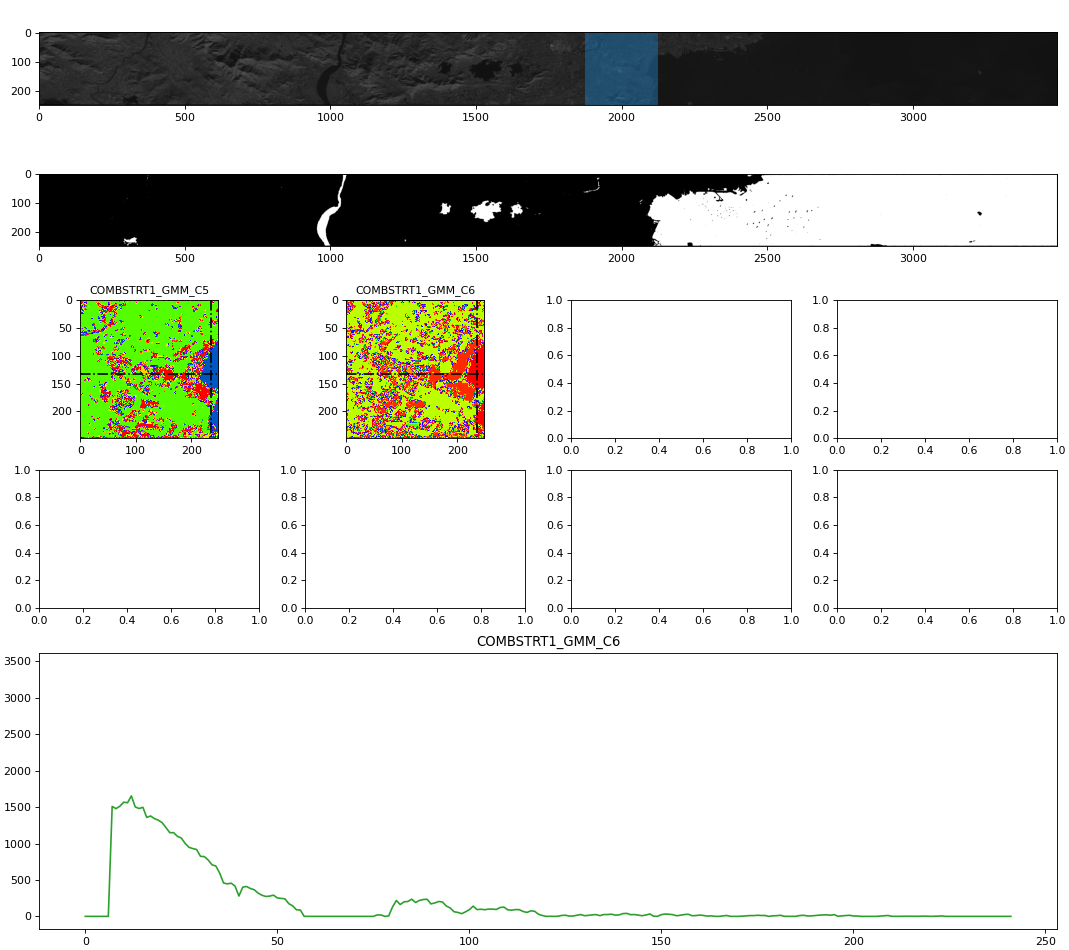

In [57]:
%matplotlib notebook
%matplotlib notebook

resultAnalysis = HSClusterAnalysis(spectral_data = specmat_sliced,
                                   spectral_img = specmat_sliced_mean,
                                   class_masks = selected_masks)

In [ ]:
# origrot_classmask = all_classification_masks['comb_kmeans_c5'].astype(np.uint8).copy() + 1
# origrot_classmask = helperHandler.rotate_image(mat = origrot_classmask, angle=-mean_angleto90)
# # origrot_classmask = np.ma.masked_where(origrot_classmask != 0, origrot_classmask)

# # Folium Map
# m = folium.Map(location=geom['coordinates'][0][0][::-1],
#                position='topright',
#                zoom_start=8)
# folium.GeoJson(geom, name='geojson').add_to(m)

# for k,v in transformed_cord.items():
#     folium.Marker([v[1],v[0]], popup=k).add_to(m)


# folium.raster_layers.ImageOverlay(image=origrot_classmask,# Longitude # Latitude
#                                   bounds=[geom['coordinates'][0][0][::-1],
#                                           geom['coordinates'][0][2][::-1]],
#                                   origin='upper',
#                                   opacity=0.9,
#                                   colormap=plt.cm.get_cmap('viridis'),
#                                   mercator_project=False,
#                                   pixelated=True,
#                                   name=None,
#                                   overlay=True,
#                                   control=True,
#                                   show=True).add_to(m)
# _=folium.LayerControl().add_to(m)
# m.save(savefile9)

In [ ]:
m

# Random Testing Space

## Find Extermity Coefficients

In [ ]:
# with open(savefile6, 'rb') as file:
#     orig_coord = pickle.load(file)
# src = rst.open(imgpaths[0])

# trnsf = src.transform
# translated_coord = {k:trnsf*tuple(list(v)[::-1]) for k,v in orig_coord.items()}
# translated_coord = {k:helperHandler.to_epsg4326(v[0],v[1], src_crs=src.crs.__str__()) for k,v in translated_coord.items()}
# print(translated_coord)

# with rasterio.open(imgpaths[0]) as dataset:
#     mask = dataset.dataset_mask()
#     for geom, val in rasterio.features.shapes(mask, transform=dataset.transform):
#         geom = rasterio.warp.transform_geom(dataset.crs, 'EPSG:4326', geom, precision=20)

        

# m = folium.Map(location=geom['coordinates'][0][0][::-1],
#                position='topright',
#                zoom_start=8)
# folium.GeoJson(geom, name='geojson').add_to(m)

# for k,v in translated_coord.items():
#     folium.Marker([v[1],v[0]], popup=k).add_to(m)


# img=tiff.imread(imgpaths[0])
# folium.raster_layers.ImageOverlay(image=img,# Longitude # Latitude
#                                   bounds=[geom['coordinates'][0][0][::-1],
#                                           geom['coordinates'][0][2][::-1]],
#                                   origin='upper',
#                                   opacity=0.5,
#                                   colormap=plt.cm.get_cmap('viridis'),
#                                   mercator_project=False,
#                                   pixelated=True,
#                                   name=None,
#                                   overlay=True,
#                                   control=True,
#                                   show=True).add_to(m)
# folium.LayerControl().add_to(m)
# helperHandler.imgN_show(img)
# with open(savefile7, 'wb') as f:
#     pickle.dump(translated_coord,f,pickle.HIGHEST_PROTOCOL)
    
# with open(savefile8, 'wb') as f:
#     pickle.dump(geom,f,pickle.HIGHEST_PROTOCOL)
# m

## Random

In [24]:
[73.03912593847224, 19.570198734016746][::-1]

[19.570198734016746, 73.03912593847224]

In [21]:
unique_models

array(['comb_gmm', 'comb_kmeans', 'combstrt1_gmm', 'combstrt1_kmeans',
       'mean_gmm', 'mean_kmeans', 'pca_100_kmeans', 'pca_25_gmm',
       'pca_25_kmeans', 'std_gmm', 'std_kmeans'], dtype='<U16')